## 3.2 线性回归从0开始实现

In [1]:
from IPython import display
from matplotlib import pyplot as plt
from tensorflow import keras
import tensorflow.keras.backend as K
import tensorflow.keras.layers as KL
import numpy as np
import random

/usr/local/anaconda3/envs/rknn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/anaconda3/envs/rknn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/anaconda3/envs/rknn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/anaconda3/envs/rknn/lib/python3.6/site-packages

### 3.2.1 生成数据集
y = Xw + b + e

其中:
* X 输入个数（特征数）为 2
* 真实权重w为[2, -3.4], 偏置b为为4.2
* e是均值0，标准差为0.01的正太分布噪音，干扰项

In [2]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = np.random.normal(scale=1, size=(num_examples, num_inputs))
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += np.random.normal(scale=0.01, size=labels.shape)

In [3]:
features[0], labels[0]

(array([ 0.64150635, -0.92275401]), 8.607542971418987)

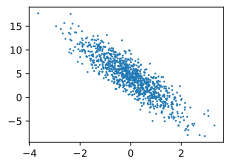

In [4]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

set_figsize()
plt.scatter(features[:, 1], labels, 1);  # 加分号只显示图

### 3.2.2 读取数据

In [5]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = np.array(indices[i: min(i + batch_size, num_examples)])
        yield features[j], labels[j]  # take函数根据索引返回对应元素
        

In [6]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break
    

[[ 1.47391928 -1.03903848]
 [ 1.07008049 -2.15790868]
 [ 0.35228461  0.61532637]
 [-0.30263317  1.17933343]
 [ 0.36994724  0.07394596]
 [-1.20090056  0.32428777]
 [-0.23500814 -1.86225433]
 [-0.08300409  0.66633495]
 [ 0.3329007   0.85059953]
 [ 1.13715512 -0.15530362]] [10.68222174 13.67301606  2.80682341 -0.41524399  4.68868624  0.69173824
 10.04388088  1.76687783  1.96579751  6.99606731]


### 3.2.3 初始化模型参数
### 3.2.4 定义模型

In [7]:
model = keras.models.Sequential([
    KL.Dense(1, input_shape=(2,), use_bias=True, 
             kernel_initializer=keras.initializers.random_normal(stddev=0.01),
             bias_initializer=keras.initializers.zeros())
])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### 3.2.5 定义损失函数

In [8]:
def squared_loss(y_true, y_pred):
    return K.square(y_pred - y_true) / 2

### 3.2.6 定义优化算法

In [9]:
class sgd(keras.optimizers.Optimizer):
    def __init__(self, lr=0.03, name="SGD", **kwargs):
        super(sgd, self).__init__(name, **kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.learningrate = K.variable(lr, name='lr')
            
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]
        
        for p, g in zip(params, grads):
            new_p = p - self.learningrate * g
            self.updates.append(K.update(p, new_p))
        return self.updates
    
    def get_config(self):
        config = super(sgd, self).get_config()
        config.update({
            "lr": self._serialize_hyperparameter("lr"),
        })
        return config
        

### 3.2.7 训练模型

In [10]:
model.compile(optimizer=sgd(lr=0.03), loss=squared_loss)
model.fit(features, labels, batch_size, 3)

Epoch 1/3
1000/1000 [==============================] - 0s 233us/sample - loss: 2.8219
Epoch 2/3
1000/1000 [==============================] - 0s 92us/sample - loss: 0.0045
Epoch 3/3
1000/1000 [==============================] - 0s 73us/sample - loss: 5.6134e-05


In [11]:
print('true_w', true_w)
print('true_b', true_b)
print('model weights', model.get_weights())

true_w [2, -3.4]
true_b 4.2
model weights [array([[ 1.9998357],
       [-3.3998976]], dtype=float32), array([4.19936], dtype=float32)]
